In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep
import os
import csv
import glob
import scipy
import pandas as pd 
import arviz as az
import seaborn as sns
import sys
from b2.gsas import GSASModel
from os.path import basename
from scipy.optimize import curve_fit
from scipy import signal

cwd = os.getcwd()
path = '/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine'
os.chdir(path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

# background subtraction (code adapted from @author: fangren) ----------------------------------------------
def file_index(index):
    if len(str(index)) == 1:
        return '00' + str(index)
    elif len(str(index)) == 2:
        return '0' + str(index)
    elif len(str(index)) == 3:
        return str(index)


def read_1D(filename):
    data = np.genfromtxt(filename, delimiter=',', skip_header = 1)
    #Qlist = data[:,0][8:1400]
    #IntAve = data[:,1][8:1400]
    Qlist = data[:,0][0:1400]
    IntAve = data[:,1][0:1400]
    return Qlist, IntAve


def select_bckgrd(background_indices):
    background_x = Qlist[background_indices]
    background_y = IntAve[background_indices]
    print (background_y[5])
    #if background_y[5] >820:
        #background_y[5] = 820
    
    return background_x, background_y


def save_results(background_x, background_y, Qlist, IntAve, index, base_filename):
    indices = range(1, 1401)
    plt.figure(1)
    plt.subplot(311)
    plt.plot(indices, IntAve)
    plt.plot(background_indices, background_y, 'o')
    
    tck = splrep(background_x,background_y)
    
    background = splev(Qlist, tck)
    
    plt.subplot(312)
    plt.plot(Qlist, IntAve)
    plt.plot(Qlist, background)
    plt.plot(background_x, background_y, 'o')
    
    
    plt.subplot(313)
    plt.plot(Qlist, (IntAve-background))
    plt.plot(Qlist, [0]*1400, 'r--')
    plt.savefig( base_filename + file_index(index) + '_bckgrd_subtracted.png' )    
    
    plt.close('all')
    
    data = np.concatenate(([Qlist], [(IntAve-background)]), axis = 0)
    np.savetxt(base_filename + file_index(index) + '_bckgrd_subtracted.csv', data.T, delimiter=",")




# peak fitting ----------------------------------------------
def func(x, *params):
    """
    create a Gaussian-Lorentzian fitted curve according to params
    """
    y = np.zeros_like(x)
    for i in range(0, len(params), 4):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        n = params[i+3]
        y = y + n * amp * np.exp(-4 * np.log(2) * ((x - ctr) / wid) ** 2) + (1 - n) * amp * wid ** 2 / 4 / (
        (x - ctr) ** 2 + wid ** 2 / 4)
    return y


def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = range(len(v))
    
    v = np.asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = float('inf'), -float('inf')
    mnpos, mxpos = float('NaN'), float('NaN')
    
    lookformax = True
    
    for i in range(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

In [2]:
# XRD used ----------------------------------------------
model_GSAS = GSASModel("/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/TaTi-B2-new-copy.gpx")

### Find background indices 

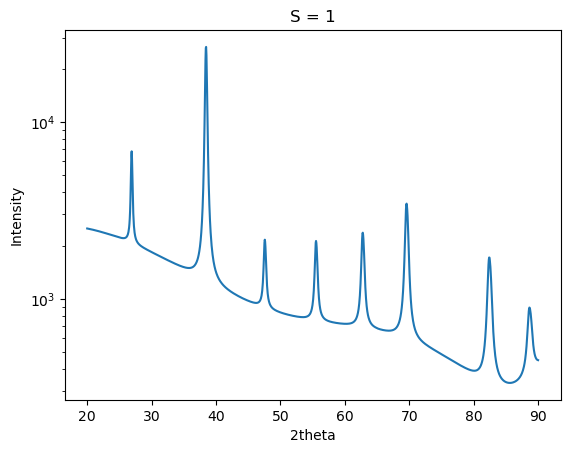

In [7]:
theta = np.round(np.linspace(20, 90, 1400), 3)
S = 1
RA = 0.5 * S + 0.5
occupancies = np.array([1-RA, 1-RA, RA, RA])
sz = 0.1
mustrain = 8000
simul = model_GSAS.forward(site_occupancies=occupancies, grainsize=sz, mustrain=mustrain)
#plt.title("S = {}, sz = {}, mustrain = {}".format(S, sz, mustrain))
plt.title("S = {}".format(S))
plt.semilogy()
plt.xlabel("2theta")
plt.ylabel("Intensity")
plt.plot(theta, simul)

In [5]:
# # try changing the background_indices to choose the best point for spline fit
# path = "/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/dataBG/"
# filename = 'findBG.csv'
# fullname = path + filename
# def read_1D(filename):
#     data = np.genfromtxt(filename, delimiter=',', skip_header = 1)
#     Qlist = data[:,0][0:1400]
#     IntAve = data[:,1][0:1400]
#     return Qlist, IntAve

# #fullname = '/Users/ritalyu/Desktop/ThesisProject/JAX/peakFitting/dataBG/findBG.csv'
# fullname = '/Users/ritalyu/Desktop/ThesisProject/JAX/peakFitting/data/test_noisy.csv'

# Qlist, IntAve = read_1D(fullname)
# x = list(range(0,1400))
# background_indices = [23, 200, 237, 487, 595, 780, 1100, 1170, 1330, 1397] 
# background_x = Qlist[background_indices]
# background_y = IntAve[background_indices]
# tck = splrep(background_x,background_y)    
# background = splev(Qlist, tck)
# plt.plot(x, IntAve)
# plt.plot(background_indices, background_y, 'o')
# plt.semilogy()
# plt.plot(x, background)
# plt.show()

### Low S, change sz

In [6]:
# logscale generate the range of sz
sz = np.logspace(-3, 0, 10)
#sz = np.linspace(0.0035, 1, 30)
sz

array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ])

In [7]:
os.chdir('/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/')

In [10]:
tth = np.round(np.linspace(20, 90, 1400), 3)
S = 0.5
sz = 0.5
mustrain_index = np.linspace(10, 300000, 30)

table_filename = []
table_diffraction = []

path = os.getcwd() + '/MidS_find_mustrain/'

# save each diffraction pattern as a csv file
# tth as the 1st column, intensity as the 2nd column
for mustrain in mustrain_index: 
    RA = 0.5 * S + 0.5
    occupancies = [1-RA, 1-RA, RA, RA]
    ycalc = model_GSAS.forward(site_occupancies=occupancies, grainsize=sz, mustrain=mustrain)
 
    table_diffraction.append(ycalc)
    filename = 'S_{}_sz_{}_mustrain_{}.csv'.format(S, sz, mustrain)
    table_filename.append(filename)
    fullname = path + filename
    np.savetxt(fullname, np.column_stack((tth, ycalc)), delimiter=',', header='2theta, intensity', comments='')

In [11]:
table_filename

['S_0.5_sz_0.5_mustrain_10.0.csv',
 'S_0.5_sz_0.5_mustrain_10354.48275862069.csv',
 'S_0.5_sz_0.5_mustrain_20698.96551724138.csv',
 'S_0.5_sz_0.5_mustrain_31043.448275862072.csv',
 'S_0.5_sz_0.5_mustrain_41387.93103448276.csv',
 'S_0.5_sz_0.5_mustrain_51732.41379310345.csv',
 'S_0.5_sz_0.5_mustrain_62076.896551724145.csv',
 'S_0.5_sz_0.5_mustrain_72421.37931034483.csv',
 'S_0.5_sz_0.5_mustrain_82765.86206896552.csv',
 'S_0.5_sz_0.5_mustrain_93110.34482758622.csv',
 'S_0.5_sz_0.5_mustrain_103454.8275862069.csv',
 'S_0.5_sz_0.5_mustrain_113799.3103448276.csv',
 'S_0.5_sz_0.5_mustrain_124143.79310344829.csv',
 'S_0.5_sz_0.5_mustrain_134488.275862069.csv',
 'S_0.5_sz_0.5_mustrain_144832.75862068965.csv',
 'S_0.5_sz_0.5_mustrain_155177.24137931035.csv',
 'S_0.5_sz_0.5_mustrain_165521.72413793104.csv',
 'S_0.5_sz_0.5_mustrain_175866.20689655174.csv',
 'S_0.5_sz_0.5_mustrain_186210.68965517243.csv',
 'S_0.5_sz_0.5_mustrain_196555.1724137931.csv',
 'S_0.5_sz_0.5_mustrain_206899.6551724138.csv'

In [12]:
len(table_filename)

30

Background substraction

In [13]:
#base_filename = 'DelmuLowS' 
folder_path = '/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/'
bkg_subtract_path = '/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/Bckgrnd_subtracted/'
if not os.path.exists(bkg_subtract_path):
    os.makedirs(bkg_subtract_path)
os.chdir(folder_path)

basefile_path = folder_path 
#background_indices = [23, 237, 470, 590, 780, 820, 905, 1100, 1170, 1330, 1397] 
#background_indices = [23, 200, 237, 470, 487, 590, 780, 1100, 1170, 1330, 1397] 
background_indices = [23, 200, 237, 487, 595, 780, 1100, 1170, 1330, 1397] 

index = 0 
while (index <= 29):
    print('processing', basefile_path + table_filename[index])
    filename = table_filename[index]
    #filename = base_filename + table_filename[index]
    Qlist, IntAve = read_1D(filename)
    background_x, background_y = select_bckgrd(background_indices)
    save_results(background_x, background_y, Qlist, IntAve, index, bkg_subtract_path)
    index += 1

processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_10.0.csv
713.5040458581067
processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_10354.48275862069.csv
721.7973209720227
processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_20698.96551724138.csv
729.5067636562168
processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_31043.448275862072.csv
737.1284963233053
processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_41387.93103448276.csv
744.5299558190751
processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_51732.41379310345.csv
751.6832579861517
processing /Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/S_0.5_sz_0.5_mustrain_62076.8965517241

FWHM calculation 

In [14]:
path = '/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/'
peak_fit_path = path + '/peak_fitting_GLS'
if not os.path.exists(peak_fit_path):
    os.makedirs(peak_fit_path)
os.chdir(bkg_subtract_path)

In [15]:
os.getcwd()

'/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/Bckgrnd_subtracted'

In [16]:
popt = np.empty(shape = (1,))
pcov = np.empty(shape = (1,))

for filename in glob.glob('*.csv'):
    if basename(filename)[0] == '0':
        print ('processing', filename)
        data = np.genfromtxt(filename, delimiter = ',',  skip_header = 1)
        Qlist = data[:,0][:1400]
        IntAve = data[:,1][:1400] 
        #IntAve = smooth(IntAve, window_len=10)
        
        #maxs, mins = peakdet(IntAve, 1.75)
        maxs, mins = peakdet(IntAve, 200)
        peaks = maxs[:,0].astype(int)

        peaks_accepted = []
        for peak in peaks:
            if Qlist[peak] < 20  or Qlist[peak] > 90:
                continue
            peaks_accepted.append(peak)
        guess = []
        low = []
        high = []
        peaks = peaks_accepted
        print(peak)

        try:
            for peak in peaks:
                #how much can the peak center move from the initial guess
                guess.append(Qlist[peak])
                low.append(Qlist[peak]-1)
                high.append(Qlist[peak]+1)

                guess.append(IntAve[peak])
                low.append(0)
                high.append(IntAve[peak]+1)

                #this appears to be the width of the peak
                guess.append(2)
                low.append(0)
                high.append(1)
                
                guess.append(2)
                low.append(0)
                high.append(1)
            #popt, pcov = curve_fit(func, Qlist, IntAve, p0=guess, bounds = (low, high))
            popt, pcov = curve_fit(func, Qlist, IntAve, p0=guess)
            fit = func(Qlist, *popt)
            plt.figure(1)
            plt.plot(Qlist, IntAve)
            plt.plot( Qlist, fit, 'r--')
            plt.plot(Qlist[peaks], IntAve[peaks], 'o')

            for i in range(0, len(popt), 4):
                ctr1 = popt[i]
                amp1 = popt[i+1]
                wid1 = popt[i+2]
                n1 = popt[i+3]
                curve1 = n1 * amp1 * np.exp( -4 * np.log(2) * ((Qlist - ctr1)/wid1)**2) + (1-n1) * amp1 * wid1**2 / 4 / ((Qlist-ctr1)**2 + wid1**2 / 4)
                plt.plot(Qlist, curve1)

            os.chdir(peak_fit_path)
            plt.savefig(basename(filename)[:-4] + '_peak_analysis_GLS')
            plt.close()

            #popt = np.reshape(popt, (int(popt.size/4), 4))
            popt = np.reshape(popt, (int(popt.size//4), 4))
            np.savetxt(basename(filename)[:-4] + '_peak_analysis_GLS.csv', popt, delimiter=",")
        except RuntimeError:
            print ("Failed to fit", filename)
            print ("used the previous peak information")
            np.savetxt(basename(filename)[:-4] + '_peak_analysis_GLS.csv', popt, delimiter=",")
        
        os.chdir(bkg_subtract_path)

In [17]:
os.getcwd()

'/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine/MidS_find_mustrain/Bckgrnd_subtracted'

In [20]:
os.chdir(peak_fit_path)
fwhm_list = []
for filename in sorted(os.listdir(os.getcwd())):
    if not filename.endswith('.csv'):
        continue
    filepath = os.path.join(os.getcwd(), filename)
    with open(filepath, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if 37 <= float(row[0]) <= 40:
                fwhm_list.append(float(row[2]))
fwhm_list

[4.481189041844573,
 -0.3201791510557893,
 0.5036838380108862,
 0.6993395032878501,
 0.89932872808568,
 1.1009929180769626,
 1.3032376097961795,
 1.5053118886593704,
 1.706643102689788,
 1.9057331454731588,
 2.103122576917815,
 2.2855034592539014,
 2.4854326362990813,
 2.6713591133773567,
 2.851904399547195,
 3.0181303054190494,
 3.1854745071692334,
 3.346050998411219,
 3.499635419238299,
 3.6461201894381197,
 3.785512489730319,
 3.9178838907761864,
 4.0433852468320435,
 4.162229941048831,
 4.274632970676534,
 4.380861212948635,
 4.481189041844573,
 4.575890403280517,
 1.4461562791187468,
 1.4652404132843604]

In [21]:
len(fwhm_list)

30

Text(0.5, 1.0, 'S = 0.5, FWHM vs. mustrain')

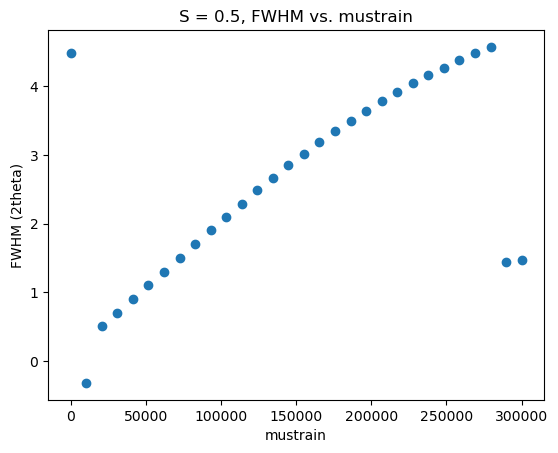

In [22]:
# plot fwhm_list vs. sz_index
plt.plot(mustrain_index, fwhm_list, 'o')
# for i, txt in enumerate(mustrain_index):
#     plt.annotate(round(txt, 2), (mustrain_index[i], fwhm_list[i]))
plt.xlabel('mustrain')
plt.ylabel('FWHM (2theta)')
plt.title('S = 0.5, FWHM vs. mustrain')

In [15]:
# make mustain_index and fwhm_list into a dataframe
df = pd.DataFrame({'mustrain': sz_index, 'FWHM': fwhm_list})
# save to csv file
df.to_csv('FWHM_vs_sz.csv', index = False)

In [ ]:
datpath=os.path.normpath('//Users/ritalyu/Desktop/ThesisProject/JAX/peakFitting/data')

files=os.listdir(datpath)
files=[i for i in files if 'exported' in i]
num=len(files)

### Generate 1000 XRDs

In [11]:
import os
os.getcwd()

'/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine'

In [12]:
os.chdir('/Users/ritalyu/Desktop/ThesisProject/JAX/TrialRangeData')

In [1]:
import numpy as np
sz_index = np.geomspace(0.0033, 0.5, 10)         # micrometer 
sz_index

array([0.0033    , 0.00576483, 0.0100707 , 0.01759271, 0.03073304,
       0.05368815, 0.09378887, 0.16384161, 0.28621811, 0.5       ])

In [2]:
mustrain_index = np.linspace(1000, 30000, 10)
mustrain_index

array([ 1000.        ,  4222.22222222,  7444.44444444, 10666.66666667,
       13888.88888889, 17111.11111111, 20333.33333333, 23555.55555556,
       26777.77777778, 30000.        ])

In [1]:
import numpy as np
S_index = np.linspace(0, 1, 10)
sz_index = np.geomspace(0.0033, 0.5, 10)         # micrometer 
mustrain_index = np.linspace(1000, 30000, 10)

In [14]:
# create pandas data frame
table_setting = []
table_diffraction_y_calc = []
table_diffraction_yy = []
for S in S_index:                                   # loop over 10 order parameters
    RA = 0.5 * S + 0.5
    occupancies = [1-RA, 1-RA, RA, RA]
    for sz in sz_index:                             # loop over 10 grain sizes
        for mustrain in mustrain_index:             # loop over 10 mustrain
            file_name = "synthetic_b2_S=" + str(round(S, 3)) + "_sz=" +str(round(sz, 3)) + "_microstrain=" + str(round(mustrain, 3))
            table_setting.append([S, sz, mustrain, file_name])
            
            y_calc = model_GSAS.forward(site_occupancies = occupancies, grainsize = sz, mustrain = mustrain)
            yy = np.random.normal(y_calc, np.sqrt(y_calc))
            table_diffraction_y_calc.append(y_calc)
            table_diffraction_yy.append(yy)

df_setting = pd.DataFrame(table_setting, columns=["order parameter", "grain size", "microstrain", "file name"])
theta = np.round(np.linspace(20, 90, 1400), 3)
df_diffraction_y_calc = pd.DataFrame(table_diffraction_y_calc, columns = theta)
df_diffraction_yy = pd.DataFrame(table_diffraction_yy, columns = theta)

In [19]:
df_diffraction_yy

,20.00,20.05,20.10,20.15,20.20,20.25,20.30,20.35,20.40,20.45,...,89.55,89.60,89.65,89.70,89.75,89.80,89.85,89.90,89.95,90.00
0,2572.256444,2560.391640,2505.188935,2504.166237,2538.352143,2546.598425,2496.993782,2515.653227,2473.843097,2478.979306,...,414.383235,388.604586,429.788412,402.291041,388.621400,422.341181,421.072990,415.554077,456.097477,377.148022
1,2520.780049,2552.177499,2484.624813,2471.793039,2383.914233,2481.127689,2472.874535,2527.744184,2506.681659,2557.743900,...,420.151590,453.615822,415.732350,429.935052,440.329664,404.232613,412.064429,406.492813,395.838116,463.062794
2,2484.351714,2580.406403,2392.180740,2528.480270,2534.340521,2568.657848,2547.776837,2506.861156,2425.609543,2516.050242,...,418.568142,438.039478,409.532203,427.872031,432.598491,392.576570,417.587412,416.725824,432.981578,409.891782
3,2518.685738,2583.781281,2525.042234,2446.818327,2519.487504,2484.248640,2508.906671,2376.764718,2514.048004,2465.157151,...,395.901041,431.920027,429.250899,442.092688,402.868606,433.539137,421.512092,418.288227,472.067555,429.212889
4,2542.766059,2443.720649,2513.027379,2517.904444,2478.847873,2495.527309,2502.666511,2465.317793,2542.961686,2547.226494,...,424.403808,435.986461,439.661311,434.779538,448.282799,405.318020,444.822690,441.040106,407.710030,388.006365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2418.669857,2543.953796,2480.884404,2516.967004,2487.036538,2451.164576,2494.963848,2469.039220,2458.497804,2482.170847,...,518.853019,484.206266,493.358882,499.874997,492.181557,489.308922,463.354445,523.271980,472.333776,475.768549
996,2469.786885,2465.018807,2594.091317,2477.343620,2498.763457,2509.849720,2463.253484,2420.039449,2608.350171,2501.727833,...,518.347416,517.688151,454.278767,474.494722,498.175285,452.383893,481.884861,497.418128,460.481493,504.767951
997,2474.025363,2547.565721,2529.308715,2441.164447,2494.629279,2399.951470,2407.663144,2466.331932,2535.642302,2559.204815,...,505.176326,493.943797,488.425921,500.492669,504.244133,519.829040,510.342762,498.839650,462.470637,473.525573
998,2515.831742,2575.088401,2514.993090,2511.561936,2533.145640,2446.553940,2534.680894,2418.240241,2465.309538,2492.256868,...,543.600301,510.773698,524.202044,533.471528,497.742678,490.428631,482.001026,520.209255,505.054496,488.949088


In [20]:
df_diffraction_y_calc

,20.00,20.05,20.10,20.15,20.20,20.25,20.30,20.35,20.40,20.45,...,89.55,89.60,89.65,89.70,89.75,89.80,89.85,89.90,89.95,90.00
0,2514.110148,2512.066776,2510.002186,2507.916558,2505.810075,2503.682913,2501.535255,2499.367284,2497.179176,2494.971106,...,415.368391,417.134392,418.933350,420.765343,422.630452,424.528770,426.460386,428.425396,430.423896,432.455986
1,2514.538265,2512.497050,2510.434635,2508.351198,2506.246922,2504.121986,2501.976572,2499.810860,2497.625028,2495.419259,...,416.144263,417.902947,419.694688,421.519561,423.377651,425.269045,427.193835,429.152110,431.143968,433.169508
2,2514.966044,2512.926982,2510.866736,2508.785487,2506.683416,2504.560701,2502.417525,2500.254071,2498.070516,2495.867038,...,416.909381,418.661008,420.445784,422.263787,424.115096,425.999800,427.917987,429.869746,431.855176,433.874372
3,2515.393487,2513.356574,2511.298495,2509.219430,2507.119559,2504.999065,2502.858123,2500.696923,2498.515637,2496.314447,...,417.663494,419.408331,421.186401,422.997782,424.842554,426.720802,428.632615,430.578083,432.557298,434.570359
4,2515.820576,2513.785811,2511.729893,2509.653009,2507.555335,2505.437053,2503.298345,2501.139392,2498.960373,2496.761468,...,418.406387,420.144699,421.916322,423.721334,425.559814,427.431845,429.337516,431.276915,433.250135,435.257274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2499.835759,2497.736283,2495.615536,2493.473712,2491.311004,2489.127604,2486.923705,2484.699502,2482.455187,2480.190954,...,501.208630,494.679435,489.071939,484.286657,480.232746,476.828664,474.001926,471.688637,469.832667,468.384920
996,2500.607687,2498.514826,2496.400807,2494.265825,2492.110077,2489.933757,2487.795190,2485.578456,2483.341743,2481.114274,...,507.936845,501.776649,496.377549,491.678202,487.618269,484.140254,481.190461,478.719499,476.682410,475.038587
997,2501.667752,2499.582025,2497.475254,2495.347637,2493.199372,2491.030658,2488.841695,2486.632685,2484.403827,2482.155322,...,512.044196,506.452546,501.466317,497.053270,493.177992,489.803800,486.894255,484.414103,482.329831,480.610053
998,2502.419171,2500.339971,2498.239837,2496.118970,2493.977573,2491.815849,2489.633999,2487.432228,2485.210740,2482.969740,...,514.179701,509.245787,504.780519,500.771947,497.203018,494.053393,491.300823,488.922244,486.894476,485.194873


In [46]:
os.chdir('/Users/ritalyu/Desktop/ThesisProject/JAX/RangeDetermine')

In [18]:
# save to csv file
df_setting.to_csv(path_or_buf="setting.csv", index = False)
df_diffraction_y_calc.to_csv(path_or_buf="diffraction_y_calc.csv", index = False)
df_diffraction_yy.to_csv(path_or_buf="diffraction_yy.csv", index = False)

the biggest ideas in the universe - sean carroll
helgoland - carlo rovelli